---
This notebook generates image variants from the vanilla SVG cards.

---

In [5]:
import multiprocessing
import os
import random
import sys

import numpy as np
from PIL import Image, ImageFilter, ImageDraw


# Setup input and output directories.
input_directory = 'card-images'
output_directories = ('rgba-images', 'rgba-data')
for output_directory in output_directories:
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Run vars.
use_multiple_processors = True
variations_per_image = 1000
  
# Cropping and resizing params.
original_card_width, original_card_height = 352, 550
aspect_ratio = 0.64
card_width = 100
card_height = int(card_width / aspect_ratio)

# White balance, rotation, blur and obfuscation params.
min_channel_high_end = 0.4
max_channel_low_end = 0.4
max_rotation = 5
max_blur = 3
max_rectangles = 5
max_rectangle_width, max_rectangle_height = card_width * 0.3, card_height * 0.3


def preprocess(input_path):
  """Preprocess images."""
  # Load.
  image = Image.open(input_path)
  
  # Crop.
  image = image.crop((0, 0, original_card_width, original_card_height))
  
  # Resize.
  image = image.resize((card_width, card_height), resample=Image.ANTIALIAS)
    
  # Rotate.
  rotation = random.choice([-1, 1]) * max_rotation * random.random()
  if rotation < 0:
    rotation += 360
  image = image.rotate(rotation, expand=False, resample=Image.BICUBIC)
    
  # Obfuscate.
  drawing = ImageDraw.Draw(image)
  rectangles = int(round(random.random() * max_rectangles))
  for _ in range(rectangles):
    width = round(random.random() * max_rectangle_width)
    height = round(random.random() * max_rectangle_height)
    color = tuple([random.choice(np.arange(0, 256)) for _ in range(3)])
    x_shift = round(random.random() * card_width)
    y_shift = round(random.random() * card_height)
    drawing.rectangle([x_shift, y_shift, x_shift+width, y_shift+height], outline=color, fill=color)
    
  # Adjust white balance.
  rmin = random.random()*min_channel_high_end
  gmin = random.random()*min_channel_high_end
  bmin = random.random()*min_channel_high_end
  rmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  gmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  bmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  new_image = np.empty((card_height, card_width, 3), dtype=np.float32)
  image = np.multiply(np.array(image), 1/255.)
  new_image[:, :, 0] = np.add(np.multiply(image[:, :, 0], (rmax-rmin)), rmin)
  new_image[:, :, 1] = np.add(np.multiply(image[:, :, 1], (gmax-gmin)), gmin)
  new_image[:, :, 2] = np.add(np.multiply(image[:, :, 2], (bmax-bmin)), bmin)
  new_image = np.multiply(new_image, 255)
  image = Image.fromarray(np.uint8(new_image))

  # Blur.
  blur = max_blur * random.random()
  image = image.filter(ImageFilter.GaussianBlur(blur))
  
  # Get data.
  rgba_data = np.array(image).reshape(3, card_height, card_width)
  
  # Parse the input path.
  filename = input_path.split('/')[-1]
  number = filename.split('-')[0]
  color = filename.split('-')[1]
  texture = filename.split('-')[2]
  shape = filename.split('-')[3].split('.png')[0]
  
  # Save.
  output_filename_base = '%s-%s-%s-%s' % (number, color, texture, shape)
  output_filename_base += '-%0.2frmin-%0.2fgmin-%0.2fbmin-%0.2frmax-%0.2fgmax-%0.2fbmax' % (
    rmin, gmin, bmin, rmax, gmax, bmax)
  output_filename_base += '-%0.2fdeg' % rotation
  output_filename_base += '-%0.2fblur' % blur
  output_filename_base += '-%srect' % rectangles
  rgba_image_path = os.path.join('rgba-images', '%s.png' % output_filename_base)
  image.save(rgba_image_path)
  rgba_data_path = os.path.join('rgba-data', '%s.png' % output_filename_base)
  np.save(rgba_data_path, rgba_data)

# Input params.
image_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory)]
inputs = image_paths * variations_per_image

# Run it.
print 'generating %s images..' % len(inputs)
if use_multiple_processors:
  pool = multiprocessing.Pool()
  for i, _ in enumerate(pool.imap_unordered(preprocess, inputs, 1)):
    sys.stdout.write('\r%0.1f%% complete..' % (100. * i / len(inputs)))
  pool.close()
  pool.join()
  sys.stdout.write('\r100% complete.')
else:
  map(preprocess, inputs)
  print 'done.'

generating 81000 images..
100% complete.

---
Display a few.

---

3-purple-solid-oval-0.15rmin-0.22gmin-0.01bmin-0.90rmax-0.80gmax-0.71bmax-359.83deg-1.56blur-2rect.png


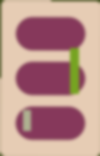

2-purple-striped-diamond-0.27rmin-0.40gmin-0.36bmin-0.79rmax-0.66gmax-0.68bmax-355.23deg-1.91blur-1rect.png


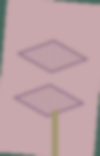

2-green-striped-oval-0.04rmin-0.31gmin-0.07bmin-0.99rmax-0.81gmax-0.80bmax-356.61deg-2.14blur-1rect.png


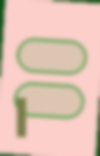

3-green-solid-oval-0.07rmin-0.36gmin-0.15bmin-0.64rmax-0.63gmax-0.74bmax-0.56deg-0.05blur-4rect.png


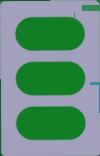

1-green-striped-oval-0.02rmin-0.38gmin-0.13bmin-0.70rmax-0.65gmax-0.87bmax-3.39deg-1.13blur-1rect.png


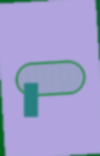

3-red-empty-oval-0.14rmin-0.12gmin-0.31bmin-0.96rmax-0.82gmax-0.67bmax-356.56deg-2.87blur-2rect.png


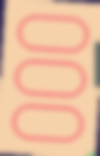

2-red-striped-bean-0.37rmin-0.19gmin-0.08bmin-0.84rmax-0.76gmax-0.90bmax-357.28deg-1.67blur-0rect.png


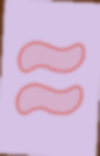

2-red-striped-oval-0.02rmin-0.09gmin-0.12bmin-0.98rmax-0.91gmax-0.62bmax-357.62deg-1.47blur-3rect.png


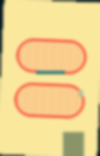

2-red-striped-bean-0.23rmin-0.10gmin-0.27bmin-0.84rmax-0.78gmax-0.95bmax-0.36deg-2.54blur-2rect.png


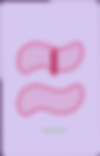

2-green-solid-oval-0.36rmin-0.37gmin-0.28bmin-0.63rmax-0.70gmax-0.84bmax-358.96deg-2.37blur-2rect.png


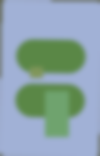

In [6]:
from IPython import display


output_directory = 'rgba-images'
images = random.sample(os.listdir(output_directory), 10)
for filename in images:
  print filename
  path = os.path.join(output_directory, filename)
  display.display(display.Image(filename=path))